# Tree-based methods

Thanks to my students Marcela Aguirre and Fabian Villena.

In [100]:
# Iris dataset
from sklearn.datasets import load_iris

# Scikit's libraries
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.externals.six import StringIO 
from sklearn.tree import export_graphviz
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn import metrics
from sklearn.metrics import make_scorer

# XGBoost
import xgboost as xgb

# Pandas
import pandas as pd

# Numpy
import numpy as np
# Set random seed
np.random.seed(0)

# Plots
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import Image  
import pydotplus

In [101]:
iris = load_iris()

# I check the information contained in iris
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names'])

In [102]:
#dataset description

#print(iris.DESCR)

In [103]:
# Create a dataframe with the four feature variables
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# View the top 5 rows
df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

In [104]:
df.shape

(150, 4)

In [105]:
# Add a new column with the species names, this is what we are going to try to predict
df['species'] = pd.Categorical.from_codes(iris.target, iris.target_names)

# You can use *sample* instead of *head* to have a random sample
df.sample(5) 

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
114                5.8               2.8                5.1               2.4   
62                 6.0               2.2                4.0               1.0   
33                 5.5               4.2                1.4               0.2   
107                7.3               2.9                6.3               1.8   
7                  5.0               3.4                1.5               0.2   

        species  
114   virginica  
62   versicolor  
33       setosa  
107   virginica  
7        setosa

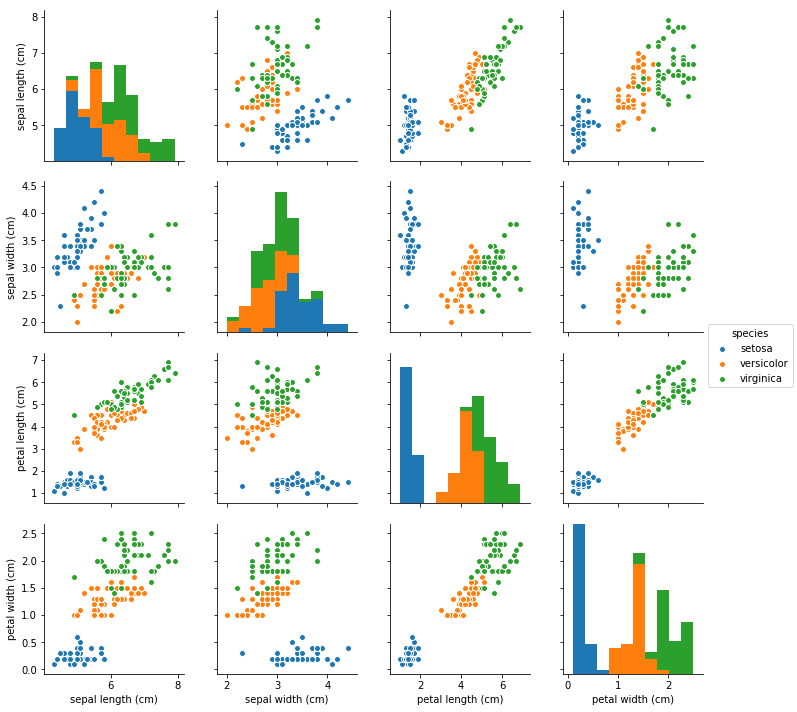

In [107]:
sns.pairplot(df, hue='species')

### Divinding in training and testing

In [44]:
# using 75% of data from training and 25% for testing
df['is_train'] = np.random.uniform(0, 1, len(df)) <= .75

df.sample(5)

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
112                6.8               3.0                5.5               2.1   
15                 5.7               4.4                1.5               0.4   
41                 4.5               2.3                1.3               0.3   
135                7.7               3.0                6.1               2.3   
96                 5.7               2.9                4.2               1.3   

        species  is_train  
112   virginica     False  
15       setosa      True  
41       setosa      True  
135   virginica     False  
96   versicolor     False

In [45]:
# Dataframes for training and testing
train, test = df[df['is_train']==True], df[df['is_train']==False]

In [46]:
# Number of observations in each dataset
print('Observations for training:', len(train))
print('Observations for testing:',len(test))

Observations for training: 114
Observations for testing: 36


In [47]:
# I move from species name to codes
y = pd.factorize(train['species'])[0]
y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [48]:
# I run RF with default values
features = df.columns[:4]
clf = RandomForestClassifier()
clf.fit(train[features], y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [49]:
# prediction for the testing subset
preds = iris.target_names[clf.predict(test[features])]

### Confusion matriz

In [50]:
pd.crosstab(test['species'], preds, rownames=['Actual Species'], colnames=['Predicted Species'])

Predicted Species  setosa  versicolor  virginica
Actual Species                                  
setosa                 11           0          0
versicolor              0          14          1
virginica               0           1          9

### Another way to visualize the confusion matrix

In [51]:
#normalised version
confusion = pd.crosstab(test['species'], preds, rownames=['Actual Species'], colnames=['Predicted Species'],normalize=True)
confusion

Predicted Species    setosa  versicolor  virginica
Actual Species                                    
setosa             0.305556    0.000000   0.000000
versicolor         0.000000    0.388889   0.027778
virginica          0.000000    0.027778   0.250000

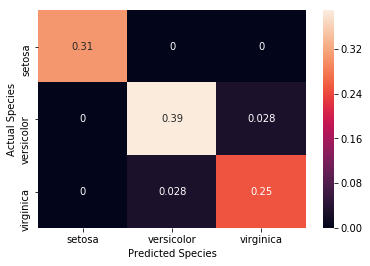

In [52]:
# seaborn is very cute
import seaborn as sns
sns.heatmap(confusion, annot=True)

### Variable importance list

In [53]:
list(zip(train[features], clf.feature_importances_))

[('sepal length (cm)', 0.060634219844178827),
 ('sepal width (cm)', 0.014494874491302583),
 ('petal length (cm)', 0.46467756010663341),
 ('petal width (cm)', 0.46019334555788516)]

In [54]:
values = clf.feature_importances_
values

array([ 0.06063422,  0.01449487,  0.46467756,  0.46019335])

<BarContainer object of 4 artists>

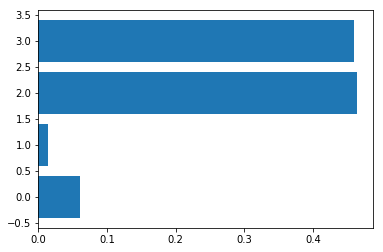

In [55]:
plt.barh(np.arange(4), values)

<BarContainer object of 4 artists>

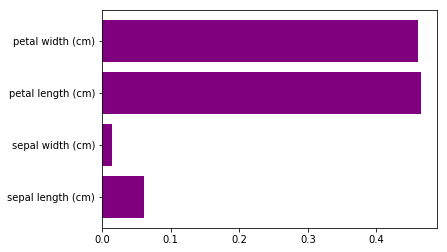

In [56]:
plt.barh(np.arange(4), values, tick_label=features, color="purple")

### Another way to do it

In [57]:
# Using an ordered dataframe
featuresImportance = pd.DataFrame({'variables':features,'importance':clf.feature_importances_}).sort_values(by='importance',ascending=False)
featuresImportance

importance          variables
2    0.464678  petal length (cm)
3    0.460193   petal width (cm)
0    0.060634  sepal length (cm)
1    0.014495   sepal width (cm)

<BarContainer object of 4 artists>

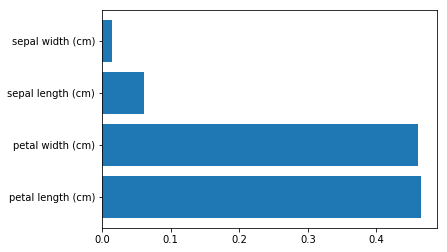

In [58]:
plt.barh(featuresImportance.variables,featuresImportance.importance)

#### Averaging over 50 runs

In [59]:
rf_vil  = []
for i in range(0,50):
    rf = clf.fit(train[features],y)
    rf_vil.append(rf.feature_importances_)
media_rf = np.mean(rf_vil, axis = 0)

df_rf = pd.DataFrame({'variables':features, 'VIL':media_rf}).sort_values(by='VIL', ascending=False)
df_rf

VIL          variables
2  0.454324  petal length (cm)
3  0.415536   petal width (cm)
0  0.105425  sepal length (cm)
1  0.024715   sepal width (cm)

<BarContainer object of 4 artists>

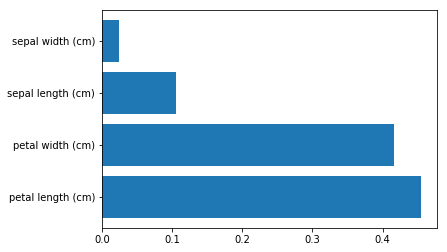

In [60]:
plt.barh(df_rf.variables,df_rf.VIL)

## Ploting a tree

### A tree with depth 2

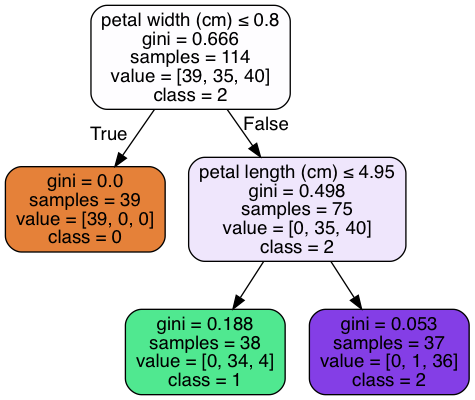

In [61]:
tree = DecisionTreeClassifier(max_features=None, max_depth=2).fit(train[features],y)

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, 
                feature_names=features, class_names=['0','1','2'], 
                impurity=True,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

### A tree built until there is one observation in each leaf 

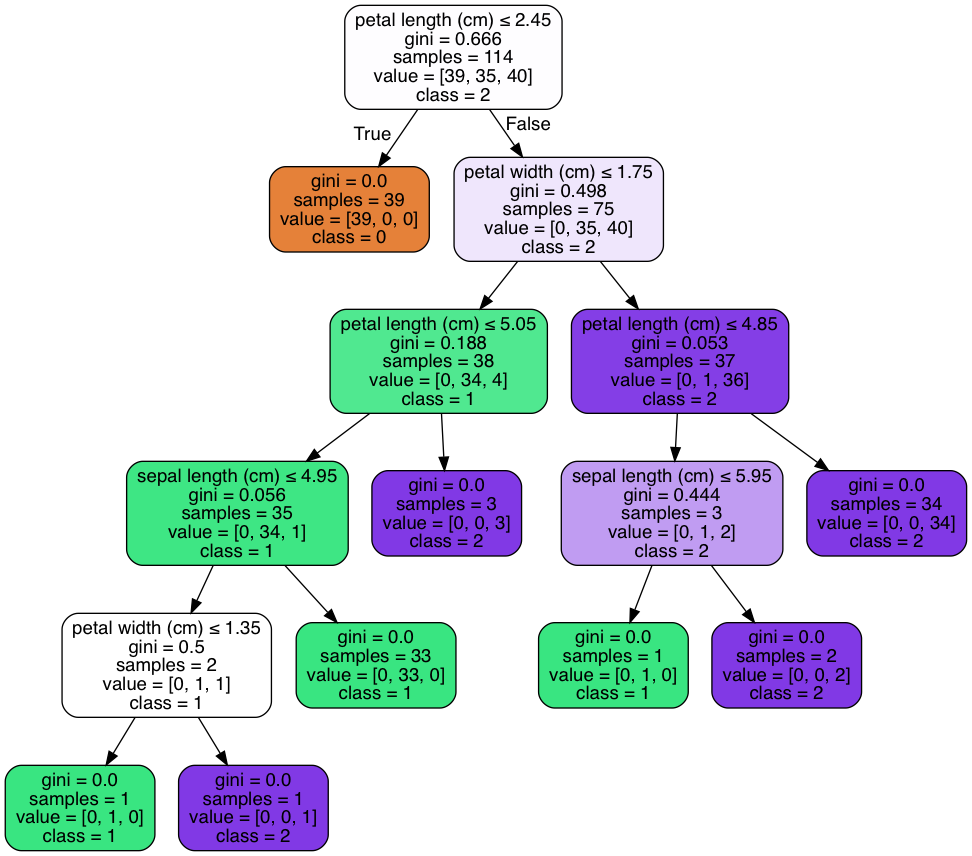

In [62]:
tree = DecisionTreeClassifier(max_features=None).fit(train[features],y)

dot_data = StringIO()
export_graphviz(tree, out_file=dot_data, 
                feature_names=features, class_names=['0','1','2'], 
                impurity=True,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

# Grid search

In [63]:
df.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)  \
0                5.1               3.5                1.4               0.2   
1                4.9               3.0                1.4               0.2   
2                4.7               3.2                1.3               0.2   
3                4.6               3.1                1.5               0.2   
4                5.0               3.6                1.4               0.2   

  species  is_train  
0  setosa     False  
1  setosa      True  
2  setosa     False  
3  setosa      True  
4  setosa     False

In [64]:
X_train = df.iloc[:,0:4]
X_train.head()

sepal length (cm)  sepal width (cm)  petal length (cm)  petal width (cm)
0                5.1               3.5                1.4               0.2
1                4.9               3.0                1.4               0.2
2                4.7               3.2                1.3               0.2
3                4.6               3.1                1.5               0.2
4                5.0               3.6                1.4               0.2

In [65]:
Y_train = pd.factorize(df['species'])[0]
Y_train

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [66]:
n_estimators = [50,100,200,400]     
max_features = [2,3,4]

In [67]:
param_test = {
    'n_estimators': n_estimators, 
    'max_features': max_features
}

gsearch = GridSearchCV(estimator = RandomForestClassifier(oob_score = True, 
                                                            max_depth=3, min_samples_leaf=1),
                       param_grid = param_test, 
                       scoring='accuracy',n_jobs=1,iid=False, cv=10)

It takes some time, don't worry 

In [68]:
gsearch.fit(X_train,Y_train)
gsearch.best_params_, gsearch.best_score_

({'max_features': 2, 'n_estimators': 400}, 0.96666666666666656)

### Heatmap

In [69]:
scores_rf = gsearch.cv_results_['mean_test_score'].reshape(len(max_features),len(n_estimators))
scores_rf

array([[ 0.95333333,  0.96      ,  0.96      ,  0.96666667],
       [ 0.96      ,  0.95333333,  0.96      ,  0.95333333],
       [ 0.95333333,  0.95333333,  0.96666667,  0.96      ]])

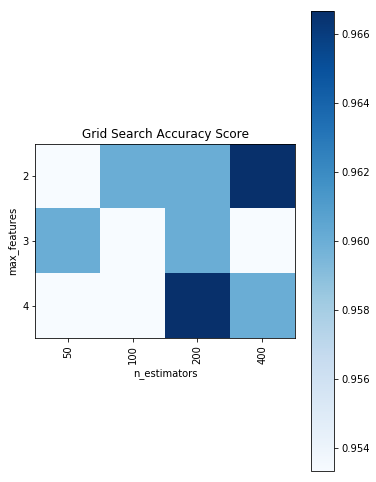

In [70]:
plt.figure(figsize=(6, 8))
plt.subplots_adjust(left=.2, right=0.95, bottom=0.15, top=0.95)
plt.imshow(scores_rf, interpolation='nearest', cmap=plt.cm.Blues)
plt.ylabel('max_features')
plt.xlabel('n_estimators')
plt.colorbar()
plt.yticks(np.arange(len(max_features)), max_features)
plt.xticks(np.arange(len(n_estimators)), n_estimators, rotation=90)
plt.title('Grid Search Accuracy Score')
plt.show()

## Different metrics to measure performance

At least using this code you cannot use it for more than two classes, but I let it anyway if in the future you have binary classification (thanks Marcela!)

In [88]:
rf_model = RandomForestClassifier(max_features = 3,oob_score = True, 
                                  n_estimators=100, max_depth=3)

acc_rf = cross_val_score(rf_model,X_train,Y_train, cv=10, scoring='accuracy')
#auc_rf = cross_val_score(rf_model,X_train,Y_train, cv=10, scoring='roc_auc')
#prec_rf = cross_val_score(rf_model,X_train,Y_train, cv=10, scoring='precision')
#recall_rf = cross_val_score(rf_model,X_train,Y_train, cv=10, scoring='recall')
#f1_rf = cross_val_score(rf_model,X_train,Y_train, cv=10, scoring='f1')

print(f'Accuracy RF: {np.mean(acc_rf)}')
#print(f'AUC RF: {np.mean(auc_rf)}')
#print(f'Precision RF: {np.mean(prec_rf)}')
#print(f'Recall RF: {np.mean(recall_rf)}')
#print(f'F1 RF: {np.mean(f1_rf)}')

Accuracy RF: 0.9666666666666666


## XGBoost

In [93]:
xgb_model =  xgb.XGBClassifier()

In [94]:
acc_xgb = cross_val_score(xgb_model,X_train,Y_train, cv=10, scoring='accuracy')
print(f'Accuracy XGB: {np.mean(acc_xgb)}')

Accuracy XGB: 0.96


One can do grid-search to find optimal parameters (the ones below are random)

In [97]:
xgb_par =  xgb.XGBClassifier(colsample_bytree=0.25,
                               gamma=0.0, 
                               learning_rate=0.0001, 
                               max_depth=3,
                               min_child_weight=1, 
                               n_estimators=100, 
                               reg_alpha=1,
                               subsample=0.7)

In [98]:
acc_xgb = cross_val_score(xgb_par,X_train,Y_train, cv=10, scoring='accuracy')
print(f'Accuracy XGB: {np.mean(acc_xgb)}')

Accuracy XGB: 0.9466666666666667


## Comparing accuracy

Text(0.5,1,'Boxplot (10-fold CV)')

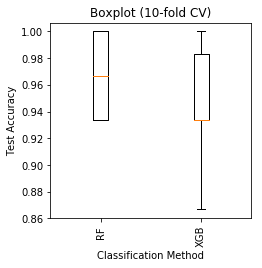

In [99]:
plt.figure(figsize=(3.6,3.6))
plt.boxplot([acc_rf,acc_xgb])
plt.xlabel('Classification Method', fontsize=10)
plt.ylabel('Test Accuracy', fontsize=10)
plt.xticks([1,2],['RF','XGB'],
          rotation=90)
plt.title('Boxplot (10-fold CV)')

#plt.savefig('boxplots.png',bbox_inches='tight')